# Python, Cython, Numba, TensorFlow の処理速度比較

In [1]:
%matplotlib inline
from IPython.display import display
import numba
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.rc('figure', figsize=(16, 4))

# 最初に Cython を使えるように Jupyter の拡張機能を有効化する

まず Cython と C コンパイラを用意する。Linux では GCC を普通にインストールすれば良い。Windows では Visual Studio 2015 Community Edition をインストールした環境であれば、特に何の追加設定も行わず使用可能だった。あるいは MinGW 環境を整えてやる必要がある。

In [2]:
%load_ext Cython

拡張有効化後、セル単位で Cython コードを生成可能になる。Cython 拡張を適用したセルで書いた関数を Python コードから呼ぶこともできる。次の `hello_cython()` 関数が呼び出せれば、 Cython またはコンパイラが正しく環境設定されている。

In [3]:
%%cython
def hello_cython():
    print("Hello, Cython!")

In [4]:
hello_cython()

Hello, Cython!


# パフォーマンス比較

以下２種類の実装方針において:

1. ループで実装
2. 「ループ変数のリスト」をベクトルとして捉え、それ全体に対する関数適用を繰り返す形で実装
2. 上記(2)と同じ考え方だがベクトルとして NumPy 配列を用いる

純粋な Python コード、Cython での実装、Numba を適用した Python コード、そして TensorFlow での GPU 演算を比較する。

## 純粋な Python コード

### ループ

ごく普通に。

In [5]:
from math import sqrt

def python_loop(n):
    """Python, loop"""
    sum_ = 0.
    width = 1. / n
    for i in range(n):
        x = i * width
        sum_ += sqrt(1 - x**2) * width
    return sum_ * 4.

### リスト

非効率的だけれど、意図を明確にするためループ変数のリストを `data` という変数にいったん格納している。なおリスト内法表記にしたりジェネレータ式にしたところで大差は無かった。

In [6]:
from math import sqrt

def python_list(n):
    """Python, list"""
    sum_ = 0.
    width = 1. / n
    data = list(range(n))
    xs = [n * width for n in data]
    return sum(sqrt(1 - x**2) * width for x in xs) * 4.

### ndarray （NumPy配列）

ループ変数を Python のリストではなく NumPy の `ndarray` にし、それに対する操作も NumPy の関数に変更。

In [7]:
import numpy as np

def python_numpy(n):
    """Python, ndarray"""
    sum_ = 0.
    width = 1. / n
    data = np.arange(n)
    xs = np.arange(n) * width
    sum_ = np.sum(np.sqrt(1 - np.power(xs, 2)) * width)
    return sum_ * 4.

## Cython 実装

Cython での実装にあたっては、Python / Cython を使っている意味を感じられる程度で最適化を止めた。実のところ NumPy 連携時は NumPy の C API を全面的に使えば速度を C 同等に引き上げられると思うのだけれど、コードの抽象度や複雑性も C 並みになってしまう。しかも、後に出てくる Numba を使う方が顕著に速くなり、しかも Python コードからの変更量も非常に小さい。なので、苦労して Cython での最適化を突き詰めるメリットはあまり感じられなかった。

### ループ（未最適化）

型アノテーションを使っていないため、基本的に Python 実装と何一つ変わらない機械語シーケンスが生成される。ほぼ恩恵が無く、`--annotate` での分析結果を見ても、最適化の余地だらけである。

In [8]:
%%cython --annotate
from math import sqrt

def cython_loop(n):
    """Cython, loop"""
    sum_ = 0.
    width = 1. / n
    for i in range(n):
        x = i * width
        sum_ += sqrt(1 - x**2) * width
    return sum_ * 4.

### ループ（最適化済み）

以下の工夫をすることで処理の高速化を図った。

1. 型アノテーションを導入
   - 変数を Python オブジェクトから C の変数にすることで演算速度を向上
2. 割り算は C の流儀 (semantics) で実行させる
   - 割り算は Python と C とで動作が違うため、何も考えずに Cython コードに割り算を書くと
     「Python の割り算を再現する C のコード」が生成され、効率が落ちる
   - 関数全体で C 流儀の割り算を使わせるなら `cython.cdivision` デコレータを使用、個別に適用するなら `cython.cdiv()` を使用
   - 参考: https://github.com/cython/cython/wiki/enhancements-division
3. 数学関数は C 標準ライブラリのものを使用
   - C-Python 間の越境コストを避ける（Python の関数を使うと呼び出すたびに Python オブジェクトと C の変数型との変換が発生する）
   - 参考: http://docs.cython.org/en/latest/src/tutorial/external.html

なお `--annotation` の結果から関数宣言の行に最適化の余地があると表示されるが、これは cdef でなく cpdef としていることが原因のもよう。Cython のコードからこの関数を呼ぶのであれば cdef で良いが、ここでは Python コードから直接呼び出びだしたいので、Python から呼ぶためのラッパーも生成してくれる cpdef をあえて使用している。

In [9]:
%%cython --annotate
cimport cython
from libc.math cimport sqrt

@cython.cdivision
cpdef double cython_loop_optimized(int n) except -1:
    """Cython, loop (optimized)"""
    cdef int i
    cdef double sum_ = 0.
    width = 1. / n
    for i in range(n):
        x = i * width
        sum_ += sqrt(1 - x**2) * width
    return sum_ * 4.

### リスト （未最適化）

単純に Cython でコンパイルしただけで、ほぼ Python 実装と変わらない。

In [10]:
%%cython --annotate
from math import sqrt

def cython_list(n):
    """Cython, list"""
    sum_ = 0.
    width = 1. / n
    data = list(range(n))
    xs = [n * width for n in data]
    return sum(sqrt(1 - x**2) * width for x in xs) * 4.

### リスト（最適化済み）

データの持ち方を `array.array` にしたり `malloc` で生メモリー領域にしたりする改善は、データだけに着目すると改善されるものの、そうして作ったデータに対して関数を一括適用してくような処理ができなくなる。なので、データの持ち方は変えず、基本的な最適化である型アノテーションと割り算の流儀の変更にとどめてある（それでも効果はある）。

In [11]:
%%cython --annotate
cimport cython
from libc.math cimport sqrt

@cython.cdivision
cpdef double cython_list_optimized(int n) except -1:
    """Cython, list (optimized)"""
    cdef double sum_ = 0.
    cdef double width = 1. / n
    data = list(range(n))
    xs = [n * width for n in data]
    return sum([sqrt(1 - x**2) * width for x in xs]) * 4.

### リスト (ndarray)

データの持ち方を NumPy の ndarray にしつつ、Cython で処理を実装。ただし、前述の通り最適化の余地は大いに残したまま止めてある。その結果、ほぼコード全体が Python 実装と変わらない状況になっており、どうやら越境コストのオーバーヘッドで遅くなってしまうもよう（実験結果は最後を参照）。

In [12]:
%%cython --annotate
cimport cython
import numpy as np
cimport numpy as np

@cython.cdivision
cpdef double cython_numpy(int n) except -1:
    """Cython, ndarray"""
    cdef double sum_ = 0.
    cdef double width = 1. / n
    xs = np.multiply(np.arange(n, dtype=np.float64), width)
    sum_ = np.sum(np.sqrt(1 - np.power(xs, 2)) * width)
    return sum_ * 4.

## Numba を Python 実装に適用

Numba による速度改善を試みるシリーズ。なお JIT コンパイルに失敗すると例外が飛ぶようにデコレーターは `njit` の方を使っている。

### ループ（未最適化）

Numba を何も考えずに適用しただけ。だというのに、この関数とは相性が良いらしく、劇的に速度が向上する。

In [13]:
import numba
from math import sqrt

@numba.njit
def numba_loop(n):
    """Numba, loop"""
    sum_ = 0.
    width = 1. / n
    for i in range(n):
        x = i * width
        sum_ += sqrt(1 - x**2) * width
    return sum_ * 4.

### ループ（最適化済み）

ごく簡単な改善として、並列処理可能なループを `numba.prange` で示してやり、かつ JIT コンパイル時にスレッド並列化を行うよう指定 （デコレータの `parallel=True` オプション)。

In [14]:
import numba
from math import sqrt

@numba.njit(parallel=True)
def numba_loop_parallel(n):
    """Numba, loop (parallel)"""
    sum_ = 0.
    width = 1. / n
    for i in numba.prange(n):
        x = i * width
        sum_ += sqrt(1 - x**2) * width
    return sum_ * 4.

numba_loop_parallel(4)
numba_loop_parallel.parallel_diagnostics(level=1)

 
 Parallel Accelerator Optimizing:  Function numba_loop_parallel, <ipython-
input-14-a3a4a8f1f0b1> (4)  


Parallel loop listing for  Function numba_loop_parallel, <ipython-input-14-a3a4a8f1f0b1> (4) 
------------------------------------------|loop #ID
@numba.njit(parallel=True)                | 
def numba_loop_parallel(n):               | 
    """Numba, loop (parallel)"""          | 
    sum_ = 0.                             | 
    width = 1. / n                        | 
    for i in numba.prange(n):-------------| #0
        x = i * width                     | 
        sum_ += sqrt(1 - x**2) * width    | 
    return sum_ * 4.                      | 
------------------------------ After Optimisation ------------------------------
Parallel structure is already optimal.
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
 


### リスト (ndarray)

ループ変数リストを ndarray に格納し、特に特別なことをせずに Numba を適用。なお NumPy 配列への処理に対する並列化は、かなりの部分を自動的に行ってくれ、 `parallel=True` にするだけで大幅な速度改善があった。

In [15]:
import numba
from math import sqrt

@numba.njit(parallel=False)
def numba_numpy(n):
    """Numba, ndarray"""
    sum_ = 0.
    width = 1. / n
    xs = np.arange(n) * width
    sum_ = np.sum(np.sqrt(1 - np.power(xs, 2)) * width)
    return sum_ * 4.

In [16]:
import numba
from math import sqrt

@numba.njit(parallel=True)
def numba_numpy_parallel(n):
    """Numba, ndarray (parallel)"""
    sum_ = 0.
    width = 1. / n
    xs = np.arange(n) * width
    sum_ = np.sum(np.sqrt(1 - np.power(xs, 2)) * width)
    return sum_ * 4.

numba_numpy_parallel(4)
numba_numpy_parallel.parallel_diagnostics(level=1)

 
 Parallel Accelerator Optimizing:  Function numba_numpy_parallel, <ipython-
input-16-1782a668ceb7> (4)  


Parallel loop listing for  Function numba_numpy_parallel, <ipython-input-16-1782a668ceb7> (4) 
--------------------------------------------------------------|loop #ID
@numba.njit(parallel=True)                                    | 
def numba_numpy_parallel(n):                                  | 
    """Numba, ndarray (parallel)"""                           | 
    sum_ = 0.                                                 | 
    width = 1. / n                                            | 
    xs = np.arange(n) * width---------------------------------| #1
    sum_ = np.sum(np.sqrt(1 - np.power(xs, 2)) * width)-------| #2, 4
    return sum_ * 4.                                          | 
------------------------------ After Optimisation ------------------------------
Parallel region 0:
+--3 (parallel, fused with loop(s): 1, 2, 4)


 
Parallel region 0 (loop #3) had 3 loop(s) fused.

# TensorFlow での実装

TensorFlow で GPU で計算させる。なお GPU 演算を念頭に置くとループを使う実装ロジックは非現実的なので、ループ変数リストをデータとして捉える方の処理だけを実装している。ただし、それだけでは面白くないので、CPU と GPU の違い、使用する浮動小数点数の精度 (bit 数) の違いも比較してみた。

In [17]:
import tensorflow as tf

def tensorflow_list(n, session, device, dtype):
    """TensorFlow, list ({}, {})""".format(device, dtype)
    with tf.device(device):
        width = tf.constant(1. / n, dtype=dtype)
        x = tf.multiply(tf.range(n, dtype=dtype), width)
        x = tf.multiply(tf.sqrt(1 - tf.pow(x, 2)), width)
        x = tf.reduce_sum(x)
        y = session.run(x)
    return y * 4

def tensorflow_list_gpu_f64(n):
    """TensorFlow, list (GPU, float64)"""
    return tensorflow_list(n, session, '/gpu:0', tf.float64)

def tensorflow_list_gpu_f32(n):
    """TensorFlow, list (GPU, float32)"""
    return tensorflow_list(n, session, '/gpu:0', tf.float32)

def tensorflow_list_cpu_f64(n):
    """TensorFlow, list (CPU, float64)"""
    return tensorflow_list(n, session, '/cpu:0', tf.float64)

def tensorflow_list_cpu_f32(n):
    """TensorFlow, list (CPU, float32)"""
    return tensorflow_list(n, session, '/cpu:0', tf.float32)

## 計測

以下、処理速度の比較実験を行う。最初に時間計測用のユーティリティを定義して、その後一気に。

In [18]:
import time
import statistics

class Stopwatch(object):
    def __init__(self):
        self._t0 = 0.
        self.intervals = []

    def __enter__(self):
        self._t0 = time.perf_counter()

    def __exit__(self, exc_type, exc_value, traceback):
        self.intervals.append(time.perf_counter() - self._t0)

    def mean(self, unit='s'):
        try:
            t = statistics.mean(self.intervals)
            return t * {'ms': 10**3, 'us': 10**6, 'ns': 10**9}.get(unit, 1)
        except statistics.StatisticsError:
            return float('nan')

    def stdev(self, unit='s'):
        try:
            t = statistics.stdev(self.intervals)
            return t * {'ms': 10**3, 'us': 10**6, 'ns': 10**9}.get(unit, 1)
        except statistics.StatisticsError:
            return float('nan')

In [19]:
from functools import partial

num_split = 1 * 1024 * 1024
num_runs = 20

with tf.Session() as session:
    test_set = [
        (Stopwatch(), python_loop),
        (Stopwatch(), python_list),
        (Stopwatch(), python_numpy),
        (Stopwatch(), cython_loop),
        (Stopwatch(), cython_loop_optimized),
        (Stopwatch(), cython_list),
        (Stopwatch(), cython_list_optimized),
        (Stopwatch(), cython_numpy),
        (Stopwatch(), numba_loop),
        (Stopwatch(), numba_loop_parallel),
        (Stopwatch(), numba_numpy),
        (Stopwatch(), numba_numpy_parallel),
        (Stopwatch(), tensorflow_list_gpu_f64),
        (Stopwatch(), tensorflow_list_gpu_f32),
        (Stopwatch(), tensorflow_list_cpu_f64),
        (Stopwatch(), tensorflow_list_cpu_f32),
    ]

    # 初回起動時のオーバーヘッドによる速度計測結果への影響を除くため
    # 一回だけ実行し、ついでに念のため計算結果を確認
    results = [f(num_split) for _, f in test_set]
    mean = statistics.mean(results)
    stdev = statistics.stdev(results) if 1 < len(results) else float("nan")
    print(f'PI = {mean} ± {stdev}')
    if 1e-6 < stdev:
        print('Something is wrong:')
        display(pd.DataFrame([{'func': f.__doc__,
                               'time': t}
                              for (sw, f), t in zip(test_set, results)]))

    # 実行時間を計測（一回だけ多く）
    for _ in range(num_runs):
        for entry in test_set:
            sw, f = entry
            with sw:
                f(num_split)

PI = 3.1415946901172815 ± 3.559764310914615e-07


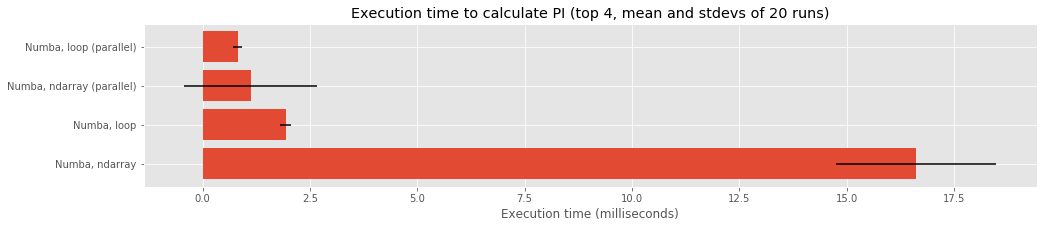

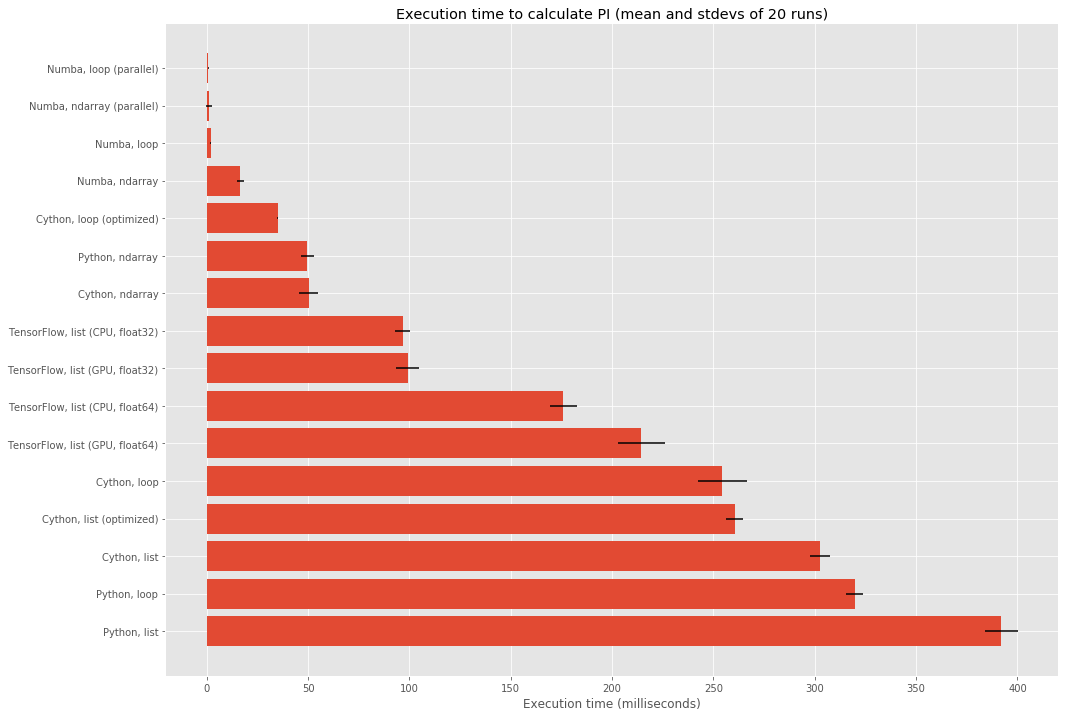

,mean (ms),stdev (ms)
method,,
"Python, list",392.040441,7.982181
"Python, loop",319.718887,4.247429
"Cython, list",302.632369,4.789312
"Cython, list (optimized)",260.460728,4.335086
"Cython, loop",254.301117,12.103771
"TensorFlow, list (GPU, float64)",214.429075,11.656024
"TensorFlow, list (CPU, float64)",175.968954,6.628822
"TensorFlow, list (GPU, float32)",99.076582,5.851160
"TensorFlow, list (CPU, float32)",96.669685,3.680104


In [20]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame([{'method': f.__doc__,
                    'mean (ms)': sw.mean() * 10**3,
                    'stdev (ms)': sw.stdev() * 10**3}
                   for sw, f in test_set])
df = df.set_index('method')
df = df.sort_values('mean (ms)', ascending=False)

# 上位4件のグラフを描画
df2 = df.iloc[-4:]
_, ax = plt.subplots(1, 1, figsize=(16, 3))
ax.set_title(f'Execution time to calculate PI (top 4, mean and stdevs of {num_runs} runs)')
ax.set_xlabel('Execution time (milliseconds)')
ax.barh(df2.index, df2['mean (ms)'], xerr=df2['stdev (ms)'], log=False)
plt.show()

# グラフを描画
_, ax = plt.subplots(1, 1, figsize=(16, 12))
ax.set_title(f'Execution time to calculate PI (mean and stdevs of {num_runs} runs)')
ax.set_xlabel('Execution time (milliseconds)')
ax.barh(df.index, df['mean (ms)'], xerr=df['stdev (ms)'], log=False)
plt.show()

# 全比較対象のデータ表を表示
df